# 0. Magic Commands

ให้ใส่ไว้บนสุดทุก Notebook เป็นการสั่งให้ Notebook ก่อนรัน ให้รีโหลด Library ภายนอกที่เรา import ไว้ใหม่โดยอัตโนมัติ 

และให้พล็อตกราฟ matplotlib ใน Output ของ cell แบบ code ได้เลย

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

Import Library ที่เราจะใช้ ในที่นี้คือ fastai version 1, fastai มี package ย่อย ๆ หลายอัน แต่ที่เราจะใช้ใน Notebook นี้คือ vision สำหรับงานเกี่ยวกับ Computer Vision และ metrics สำหรับวิเคราะห์ประสิทธิภาพของ Model

การ import * หมายความว่า import ทุกอย่างที่อยู่ใน package ทำให้เราไม่ได้ต้องมา import ทีละ class การ import แบบนี้ เหมาะสำหรับการทดลองอะไรใหม่ ๆ เพราะเราไม่ต้องย้อนมาแก้ import ทุกครั้งเมื่อต้องการใช้ class ใหม่ ๆ แต่ไม่แนะนำสำหรับใช้งานจริงบน Production

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล

ในเคสนี้ เราจะใช้ข้อมูลจาก [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) ซึ่งเป็นชุดข้อมูลรูปภาพหมา 25 พันธุ์ และรูปแมว 12 พันธุ์ รวมเป็น 37 หมวดหมู่ 

อ้างอิงจากใน paper ในปี 2012 โมเดลที่ดีที่สุด สามารถทำนายพันธุ์สัตว์ ได้ถูกต้อง 59.21% โดยโมเดลนั้น ออกแบบมาเฉพาะทาง สำหรับแยกรูปสัตว์ หัวสัตว์ ตัวสัตว์ โดยเฉพาะ (สมัยนันยังไม่ใช่ Deep Learning)

เรามาดูกันว่าเราจะใช้ Deep Learning ทำนายพันธุ์หมาแมวจากรูป ได้ถูกต้องแม่นยำกว่าหรือไม่ 

URL ของ Dataset ที่เราจะ Download มาใช้

In [3]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

ฟังก์ชัน untar_data จะดาวน์โหลด Dataset และ Extract ให้เราอัตโนมัติ ไว้ใน $HOME/.fastai/data เวลาเรารันใหม่ จะได้ไม่ต้อง Download ใหม่ทุกครั้ง เมื่อแตกไฟล์ออกมาแล้ว ก็ ls ดูว่ามีโฟล์เดอร์อะไรอยู่บ้าง

In [4]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/models'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/image_gen'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/small-256')]

ที่เราสนใจตอนนี้มี 2 path คือ images ที่เก็บรูป และ annotations ที่เก็บข้อมูลประกอบ

In [5]:
path_annotations = path/'annotations'
path_images = path/'images'

ลอง ls ดูใน path_annotations จะเห็นว่ามีไฟล์ข้อมูลประกอบรูปหลายไฟล์ด้วยกัน

In [6]:
path_annotations.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/test.txt'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/xmls'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations/README')]

## Label ชื่อพันธุ์ อยู่ในชื่อไฟล์ ##

ดึงรายชื่อไฟล์จาก path_images และแสดงรายการ 10 ไฟล์แรก

สังเกตว่าทั้งหมดเป็นรูปนามสกุล jpg อยู่ใน path ด้วยกัน ชื่อไฟล์เป็นชื่อพันธุ์ ตามด้วย _ ตามด้วย เลข Running ตามด้วย .jpg

In [7]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_100.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_82.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_180.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/german_shorthaired_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/english_setter_110.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/english_setter_60.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/scottish_terrier_155.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Ragdoll_114.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pug_144.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Siamese_116.jpg')]

# 3. เตรียมข้อมูล

ก่อนนำข้อมูลใด ๆ มาเทรน Model เราต้องมีการเตรียมข้อมูล ให้อยู่ในรูปแบบที่เหมาะสมเสียก่อน

batchsize หมายถึงให้ป้อนข้อมูลให้ Model ทีละ 64 records, GPU สามารถทำงานได้รวดเร็ว เพราะ ข้อได้เปรียบของ GPU คือมี Core จำนวนมาก การป้อนข้อมูลรูปแบบคล้าย ๆ กันให้ GPU ไปทำงานพร้อม ๆ กันหลาย ๆ Record ในทีเดียว จะเร็วกว่าใช้ CPU ทำงานไปทีละ Record มากกว่า 100 เท่า

random seed หมายถึง กำหนดค่าเริ่มต้นของการสุ่ม เพื่อให้รันทุกครั้งแล้วได้เหมือนเดิมทุกครั้ง จะได้สะดวกในการเปรียบเทียบ แต่ไม่แนะนำสำหรับงาน Production

regex หมายถึง เราจะใช้ Regular Expression ตัดชื่อไฟล์ดูจากท้ายสุด ($), ดู .jpg, ดูตัวเลข (d+), ดู _ แล้วเอาตัวอักษรทั้งหมด ก่อนถึง / มาเป็น label ชื่อพันธุ์

In [8]:
batchsize = 64
np.random.seed(123)
regex_pattern = r'/([^/]+)_\d+.jpg$'

from_name_re คือ การสร้าง DataBunch โดยใช้ regex_pattern (Regular Expression) จาก ชื่อไฟล์มาเป็น labe

* ds_tfms คือ Dataset Transforms การแปลงข้อมูลรูปภาพ เช่น ย่อขยาย crop ปรับสี ความสว่าง etc. จะพูดถึงในเรื่อง Data Augmentation ตอนนี้ยังไม่ต้องสนใจ ให้ใช้ Default จาก get_transforms ไปก่อน
* size คือ resize รูปทั้งหมดให้เป็น 244 x 244 pixels
* bs คือ batchsize
* normalize คือการแปลงข้อมูล ตาม imagenet_stats จากรูปสี จาก 0-255 x 3 channels RGB ให้มี Mean = 0 และ Standard Deviation = 1

*ที่ไม่ได้ใส่เป็น parameter ได้แก่ valid_pct คือ ค่า Percent สำหรับ แบ่ง train/valid split ซึ่งค่า Default คือ 20%*


In [9]:
databunch = ImageDataBunch.from_name_re(path_images, filenames, 
                                   regex_pattern, ds_tfms=get_transforms(), 
                                   size=224, bs=batchsize).normalize(imagenet_stats)

เราจะได้ DataBunch บรรจุ train Dataset จำนวน 5912 record และ validation Dataset จำนวน 1478 record หรือ 1478 / (1478+5912) = 20%

In [10]:
len(databunch.train_ds), len(databunch.valid_ds)

(5912, 1478)

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ชื่อพันธุ์ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 12 x 9 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

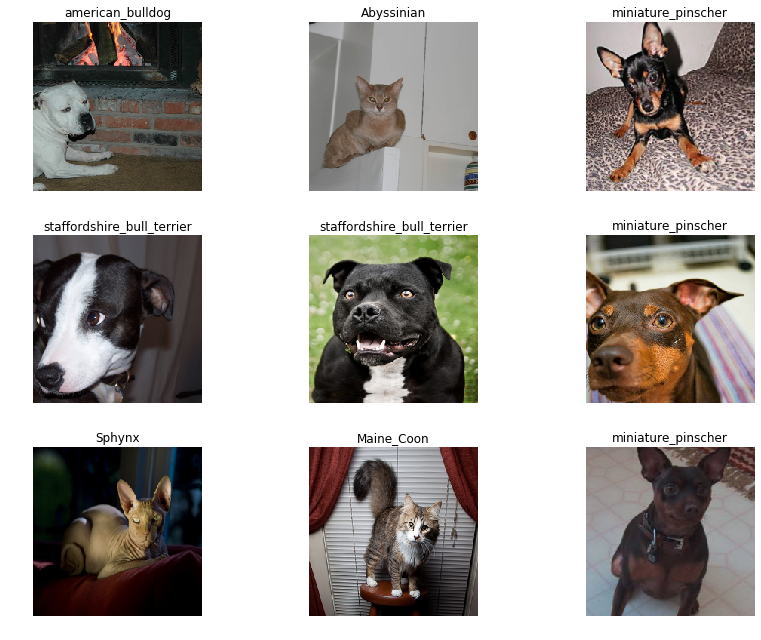

In [11]:
databunch.show_batch(rows=3, figsize=(12, 9))

ดู label พันธุ์หมาแมวทั้งหมด หรือ class ทั้งหมด ที่มีใน Dataset

In [12]:
print(databunch.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


c จำนวน label ที่จะนำไปใช้ใน model

In [13]:
print(databunch.c)

37


จำนวนพันธุ์ใน dataset

In [14]:
len(databunch.classes)

37

# 4. สร้างโมเดลแรก

สร้าง CNN Learner ด้วยฟังก์ชัน cnn_learner ระบุ databunch ของข้อมูลที่จะใช้เทรน, model ที่ต้องการ Transfer Learning จาก, metrics การวัดผลในเคสนี้เราจะใช้ Error Rate

*โดย default cnn_learner จะลบ layer สุดท้ายของ model ที่ดาวน์โหลดมาทิ้งไป และแทนที่ด้วย Layer ใหม่ ที่มี 37 Output เหมือนกับ databunch ของเรา*

In [15]:
learner = cnn_learner(databunch, models.resnet34, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล

ลอง fit ด้วย ค่า default จำนวน 4 epoch

* 1 epoch คือ ใช้ป้อนข้อมูล หมด Dataset 1 รอบ
* fit_one_cycle คือ fit แบบพิเศษ มองเป็น cycle ไม่ใช่ epoch เดี๋ยวจะอธิบายต่อไป

In [16]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.340209,0.352989,0.897835,00:22
1,0.534212,0.263595,0.916779,00:22
2,0.328196,0.238523,0.923545,00:22
3,0.256444,0.224961,0.926928,00:22


## สำเร็จแล้ว ##

เพียงแค่เวลาไม่ถึง 2 นาที เราเทรน Model ได้ accuracy ประมาณ 0.92 หรือ ความแม่นยำประมาณ 92%

เปรียบเทียบกับ paper เมื่อปี 2012 ที่ได้ 59.21% หรือเปรียบเทียบกับมนุษย์ คงเป็นเรื่องยาก ถ้าให้เราดูรูปหมาแมว แล้วให้ทายว่าเป็นพันธุ์อะไร 1 ใน 37 สายพันธุ์ แต่ Model นี้สามารถทายได้ถูกต้องถึง 92% โดยใช้เวลาในการเรียนรู้เพียงแค่ 2 นาทีเท่านั้น 

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [17]:
learner.save('resnet34-1')

# 6. ดูผลลัพธ์

ถ้าเราดูแค่ accuracy อย่างเดียว เราอาจจะไม่เห็นภาพว่า Model ทำงานได้ผลลัพธ์อย่างไร 

เราจะสร้าง ClassificationInterpretation เป็น class ที่มาช่วยตีความผลลัพธ์ ให้เราดูเข้าใจง่ายขึ้น

In [18]:
interpretation = ClassificationInterpretation.from_learner(learner)

สั่งให้ plot_top_losses คือ แสดง record ที่ ค่า loss มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด 9 อันดับแรก 

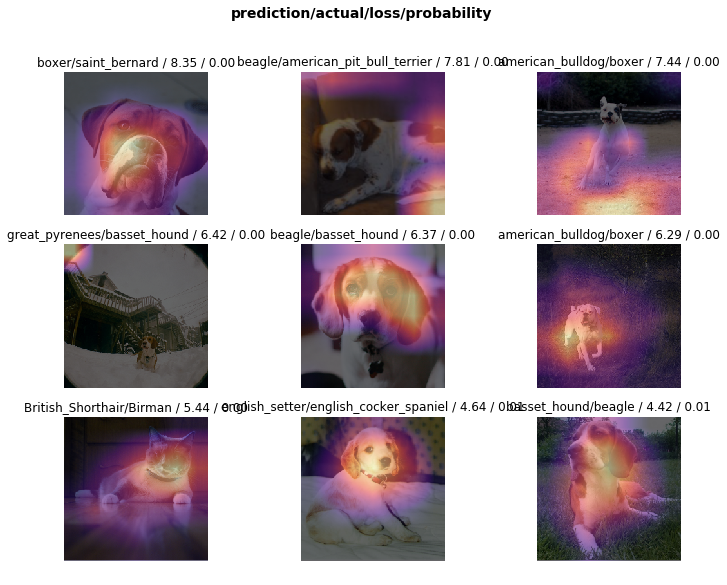

In [19]:
interpretation.plot_top_losses(9, figsize=(12,9))

จะเห็นได้ว่ายากจริง ๆ เนื่องจากหมาและแมวบางพันธุ์ก็หน้าตารูปร่างใกล้เคียงกัน

*จากรูป plot_top_losses มีการแสดง heat map สีแดง ให้ดูด้วยว่า model พิจารณาเน้นจากส่วนไหนของรูปเป็นหลัก เรียกว่า Attention ซึ่งจะอธิบายต่อไป*

สั่ง plot_confusion_matrix จะแสดงตาราง Confusion Matrix ตัดกันของหมวดหมู่ทั้งหมด 37 x 37 ว่าข้อมูลจริงคือพันธุ์อะไร (Row) แล้วโมเดลทายว่าพันธุ์อะไร (Column) สังเกตุที่ทายถูกจะเป็นเส้นแทยงมุมตรงกลาง

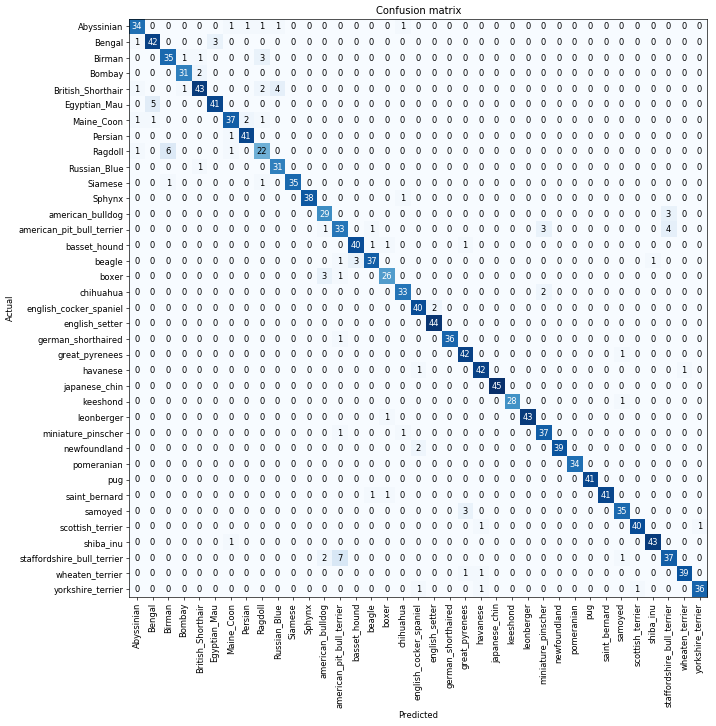

In [20]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

เนื่องจาก 37 พันธุ์ เรียกว่าค่อนข้างมาก ทำให้ตารางมีขนาดใหญ่ ตัวหนังสือเลยมีขนาดเล็ก อ่านยาก แต่เราสามารถดูคราว ๆ ได้ว่าส่วนใหญ่ทายถูก มี 1 และ 2 อยู่กระจาย ๆ ไป

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [21]:
interpretation.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Ragdoll', 'Birman', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Birman', 'Ragdoll', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3),
 ('beagle', 'basset_hound', 3),
 ('boxer', 'american_bulldog', 3),
 ('samoyed', 'great_pyrenees', 3),
 ('Bombay', 'British_Shorthair', 2),
 ('British_Shorthair', 'Ragdoll', 2),
 ('Maine_Coon', 'Persian', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('newfoundland', 'english_cocker_spaniel', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

เราสามารถเอาชื่อพันธุ์ไป Search Google Image ดูได้ ว่าทั้ง 2 พันธุ์หน้าตาคล้ายกันจริง ๆ

# 7. ดูสถิติของโมเดล

เรามาดูกราฟ Train Loss และ Validation Loss ตามจำนวน Batch ข้อมูลที่เราป้อนให้โมเดล

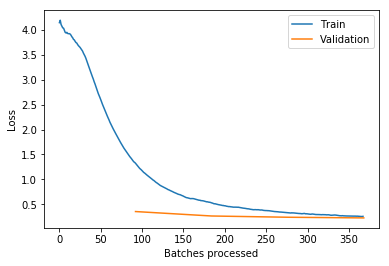

In [22]:
learner.recorder.plot_losses()

กราฟค่า Learning Rate ตามจำนวน Iteration ของการเทรน จะเห็นได้ว่า Learning Rate ไม่คงที เป็นความพิเศษของ fit_one_cycle ที่ไว้เราจะอธิบายต่อไป

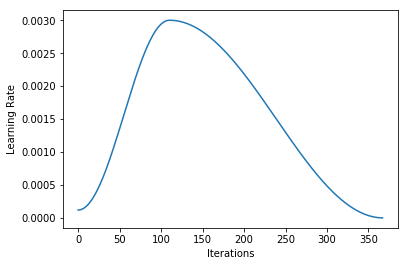

In [23]:
learner.recorder.plot_lr()

เรามาดูกราฟ accuracy ตามจำนวน Batch ข้อมูลที่เราป้อนให้โมเดล ไปสูงสุดประมาณ 92.5%

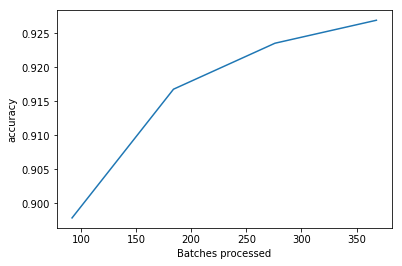

In [24]:
learner.recorder.plot_metrics()

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [25]:
# learner.load('resnet34-1')

# 8. เทรนต่อ

unfreeze layer อื่น ๆ เนื่องจาก cnn_learner ที่เราดาวน์โหลด resnet34 มาใช้นั้น Layer อื่น ๆ นอกจาก Layer สุดท้าย ได้ถูก freeze ไว้ คือจะไม่มีการเทรนต่อ ที่เราเทรนตอนแรก คือ เทรนเฉพาะ Layer สุดท้ายที่สร้างใหม่เท่านั้น

In [28]:
learner.unfreeze()

In [26]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


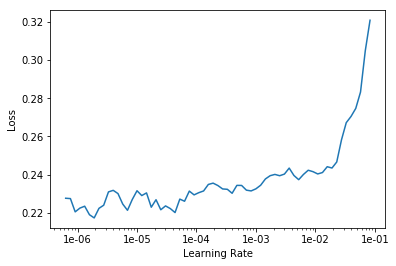

In [27]:
learner.recorder.plot()

In [29]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.240009,0.219088,0.926928,00:23
1,0.202379,0.210816,0.933694,00:23
2,0.163217,0.194651,0.934371,00:23


In [30]:
learner.save('resnet34-2')

# 9. เปรียบเทียบผลลัพธ์

In [31]:
interpretation = ClassificationInterpretation.from_learner(learner)

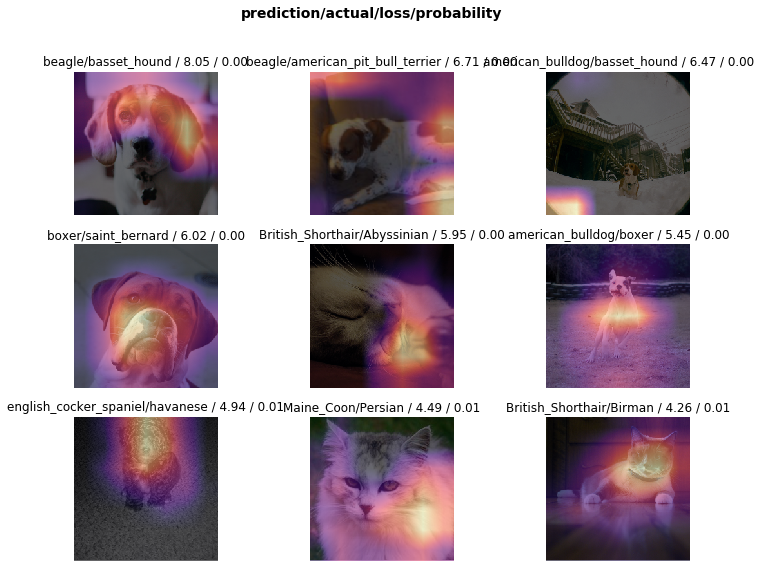

In [32]:
interpretation.plot_top_losses(9, figsize=(12,9))

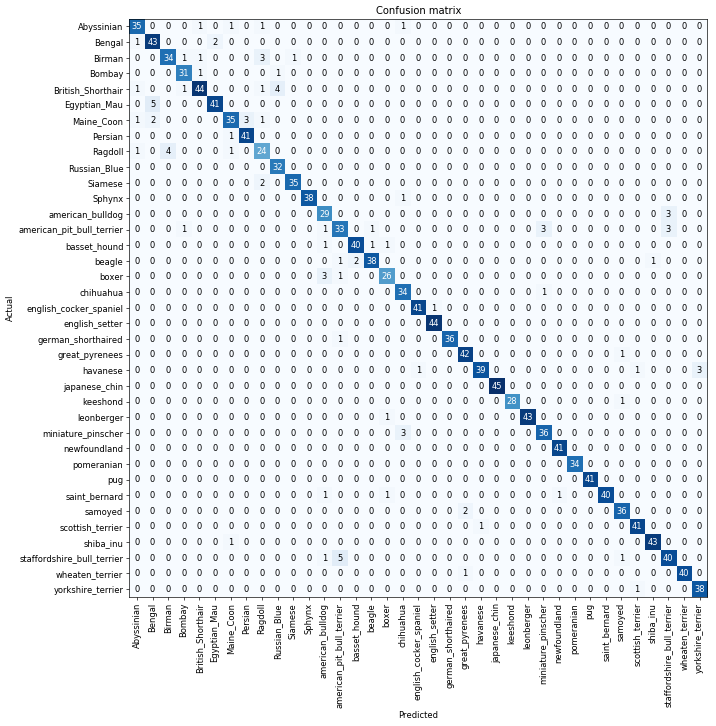

In [33]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [34]:
interpretation.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Ragdoll', 'Birman', 4),
 ('Birman', 'Ragdoll', 3),
 ('Maine_Coon', 'Persian', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('boxer', 'american_bulldog', 3),
 ('havanese', 'yorkshire_terrier', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Siamese', 'Ragdoll', 2),
 ('beagle', 'basset_hound', 2),
 ('samoyed', 'great_pyrenees', 2)]

ดูสถิติของโมเดล

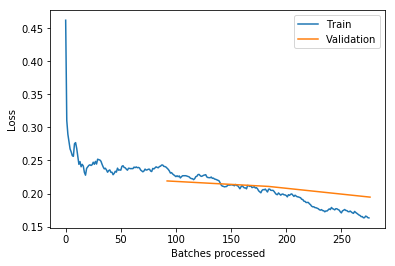

In [35]:
learner.recorder.plot_losses()

กก

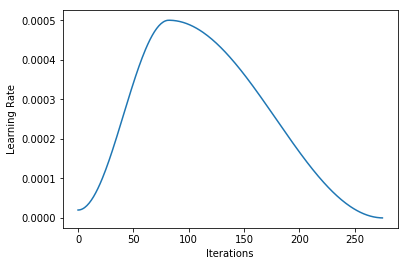

In [36]:
learner.recorder.plot_lr()

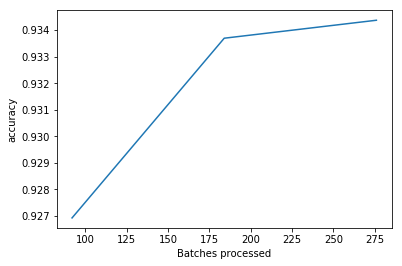

In [37]:
learner.recorder.plot_metrics()

In [38]:
# learn.load('resnet34-2')

# 10. สรุป



# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 1](https://course.fast.ai/videos/?lesson=1)